In [15]:
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
from utils import *
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sc
import scipy.stats as ss
import xgboost as xgb

In [77]:
# load training data
a_train = pd.read_csv(DATA_PATHS_IND['A']['train'], index_col='id')
b_train = pd.read_csv(DATA_PATHS_IND['B']['train'], index_col='id')
c_train = pd.read_csv(DATA_PATHS_IND['C']['train'], index_col='id')

## Eliminate NaNs

There are some columns which are repleted with nan values. Lets eliminate them

In [78]:
def eliminate_nan_cols(df, threshold=0.4):
    # threshold is the proportion of nans that determines when 
    # a column should be deleted. For example, when 40% of the values
    # are nans
    nan_count = df.isnull().sum() > int(len(df) * threshold)
    values = np.array(nan_count.values)
    cols = np.array(nan_count.index)
    cols = cols[values]
    return df.drop(cols, axis=1)

In [79]:
tr = 0.4
print("A columns before eliminating nans: {}".format(len(a_train.columns.tolist())))
print("B columns before eliminating nans: {}".format(len(b_train.columns.tolist())))
print("C columns before eliminating nans: {}".format(len(c_train.columns.tolist())))

a_train = eliminate_nan_cols(a_train, threshold=tr)
b_train = eliminate_nan_cols(b_train, threshold=tr)
c_train = eliminate_nan_cols(c_train, threshold=tr)

print("A columns after eliminating nans: {}".format(len(a_train.columns.tolist())))
print("B columns after eliminating nans: {}".format(len(b_train.columns.tolist())))
print("C columns after eliminating nans: {}".format(len(c_train.columns.tolist())))

A columns before eliminating nans: 43
B columns before eliminating nans: 226
C columns before eliminating nans: 43
A columns after eliminating nans: 43
B columns after eliminating nans: 202
C columns after eliminating nans: 43


Great, only B had some massive nan columns. Lets proceed to eliminate highly correlated columns

## Eliminating highly correlated columns

We will use Cramer's correlation equation for this

In [80]:
# Lets filter out the columns with high correlation
def cramers_corrected_stat(confusion_matrix):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))

def get_corr_matrix(df):
    df_objs = df.select_dtypes(include=['O'])
    del df_objs['country']
    corr_matrix = pd.DataFrame(columns=df_objs.columns, index=df_objs.columns.tolist())
    with tqdm(total=len(corr_matrix.columns.tolist()) * len(corr_matrix.columns.tolist())) as pbar:
        for col1 in df_objs.columns.tolist():
            for col2 in df_objs.columns.tolist():
                if col1 != col2:
                    confusion_matrix = pd.crosstab(df_objs[col1], df_objs[col2])
                    corr = cramers_corrected_stat(confusion_matrix)
                else:
                    corr = 1
                corr_matrix.loc[col1, col2] = corr
                pbar.update(1)
    
    return corr_matrix

def get_correlated_columns(corr_matrix, threshold=0.5):
    cols = {}
    for c1 in corr_matrix.columns.tolist():
        s = corr_matrix.loc[c1]
        s = s[s > threshold]
        s = list(s.index)
        s.remove(c1)
        cols[c1] = s

    cols = {k: cols[k] for k in cols if cols[k]}
    return cols

In [81]:
a_corr_matrix = get_corr_matrix(a_train)
b_corr_matrix = get_corr_matrix(b_train)
c_corr_matrix = get_corr_matrix(c_train)

100%|██████████| 1225/1225 [00:08<00:00, 148.53it/s]


In [82]:
tr = 0.7
a_corr_cols = get_correlated_columns(a_corr_matrix, threshold=tr)
b_corr_cols = get_correlated_columns(b_corr_matrix, threshold=tr)
c_corr_cols = get_correlated_columns(c_corr_matrix, threshold=tr)

In [113]:
# Lets delete the highly correlated columns in a greedy manner
def delete_columns(df, dict_cols):
    to_delete = list(set([elem for values in dict_cols.values() for elem in values]))
    return df.drop(to_delete, axis=1)


a_train_small = delete_columns(a_train, a_corr_cols)
b_train_small = delete_columns(b_train, b_corr_cols)
c_train_small = delete_columns(c_train, c_corr_cols)


print("Columns removed from A: {}".format(len(a_train.columns) - len(a_train_small.columns)))
print("Columns removed from B: {}".format(len(b_train.columns) - len(b_train_small.columns)))
print("Columns removed from C: {}".format(len(c_train.columns) - len(c_train_small.columns)))

Columns removed from A: 26
Columns removed from B: 176
Columns removed from C: 19


In [114]:
a_train_small.head()

,iid,gtnNTNam,SWoXNmPc,eXbOkwhI,OdXpbPGJ,XONDGWjH,FPQrjGnS,UsmeXdIS,igHwZsYz,AoLwmlEH,jYpOAjPW,QvgxCmCV,kvMGuSDN,ukWqmeSS,MgCoFhXK,poor,country
id,,,,,,,,,,,,,,,,,
80389,1,SSvEP,onRNG,YXCNt,4.0,oArAw,scxJu,pdgUV,YwljV,XNPgB,KOjYm,hCKQi,vtkRP,181,uEstx,True,A
80389,2,CXizI,onRNG,YXCNt,4.0,ccbZA,scxJu,pdgUV,YwljV,XNPgB,KOjYm,hCKQi,Qydia,141,uEstx,True,A
80389,3,CXizI,NDnCs,YXCNt,4.0,fOUHD,bJTYb,olfwp,flBEG,vSaJn,KOjYm,AyuSE,Qydia,41,gCSRj,True,A
80389,4,CXizI,onRNG,YXCNt,NaN,fOUHD,bJTYb,olfwp,flBEG,vSaJn,KOjYm,AyuSE,Qydia,16,uEstx,True,A
39883,1,HIvIU,onRNG,YXCNt,4.0,oArAw,scxJu,IZbuU,YwljV,OeQKE,KOjYm,hCKQi,Qydia,381,uEstx,False,A


## Check correlation between remaining columns and 'poor' label

In [115]:
def get_poor_correlation(df):
    df_objs = df.columns.tolist()
    df_objs.remove('poor')
    corr_matrix = pd.DataFrame(columns=['poor'], index=df_objs)
    with tqdm(total=len(df_objs)) as pbar:
        for col in df_objs:
            confusion_matrix = pd.crosstab(df['poor'], df[col])
            corr = cramers_corrected_stat(confusion_matrix)
            corr_matrix.loc[col, 'poor'] = corr
            pbar.update(1)
    return corr_matrix

In [116]:
a_corr_poor = get_poor_correlation(a_train_small)
b_corr_poor = get_poor_correlation(b_train_small)
c_corr_poor = get_poor_correlation(c_train_small)

 94%|█████████▍| 15/16 [00:00<00:00, 145.11it/s]/home/eze/.miniconda3/envs/poverty/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  
100%|██████████| 23/23 [00:00<00:00, 142.41it/s]


In [117]:
a_corr_poor

,poor
iid,0.122172
gtnNTNam,0.112467
SWoXNmPc,0.0802082
eXbOkwhI,0.00955397
OdXpbPGJ,0.155376
XONDGWjH,0.118974
FPQrjGnS,0.190537
UsmeXdIS,0.108929
igHwZsYz,0.317109
AoLwmlEH,0.116587


In [118]:
a_useful_cols = a_corr_poor[a_corr_poor['poor'] > 0.1].index.tolist() + ['poor']
a_useful_cols

['iid',
 'gtnNTNam',
 'OdXpbPGJ',
 'XONDGWjH',
 'FPQrjGnS',
 'UsmeXdIS',
 'igHwZsYz',
 'AoLwmlEH',
 'QvgxCmCV',
 'ukWqmeSS',
 'poor']

In [119]:
b_corr_poor

,poor
iid,0.0773226
bmhTgzYu,0.0168214
SZucUQmM,0.00833443
EfqFGRSF,0.0163202
TJGiunYp,0.088486
kgVoFHRj,0.0410195
esHWAAyG,0.0925342
gKsBCLMY,0
mlyFwTHy,0
HaaXLOfY,0


In [120]:
b_useful_cols = b_corr_poor[b_corr_poor['poor'] > 0.05].index.tolist() + ['poor']
b_useful_cols

['iid',
 'TJGiunYp',
 'esHWAAyG',
 'fwRLKHlN',
 'dnmwvCng',
 'nkxrhykC',
 'uDVGRBVU',
 'wJthinfa',
 'ulQCDoYe',
 'poor']

In [121]:
c_corr_poor

,poor
iid,0.192184
OoqEwyJF,0.00717194
vIUDQhEE,0.0157164
skzSFBmO,0.0262353
AOSWkWKB,0.207754
gBTGbFhG,0.0361314
XKQWlRjk,0.163072
CggtnNTN,0.0147132
tOfmAJyI,0.126921
vWNISgEA,0.0719912


In [122]:
c_useful_cols = c_corr_poor[c_corr_poor['poor'] > 0.1].index.tolist() + ['poor']
c_useful_cols

['iid',
 'AOSWkWKB',
 'XKQWlRjk',
 'tOfmAJyI',
 'XKyOwsRR',
 'CgAkQtOd',
 'gxCmCVUk',
 'qGqYslGF',
 'ShCKQiAy',
 'VGJlUgVG',
 'poor']

Lets work with those columns only:

In [123]:
a_train_small = a_train_small[a_useful_cols + ['country']]
b_train_small = b_train_small[b_useful_cols + ['country']]
c_train_small = c_train_small[c_useful_cols + ['country']]

## Plot columns values distribution

In [124]:
def get_object_columns(df):
    obj = df.select_dtypes(include=['O'])
    del obj['country']
    return obj


def get_numeric_columns(df):
    obj = df.select_dtypes(include=['int64', 'float64'])
    return obj


def convert_objs_to_cat(df):
    """
    df must contain only Object columns
    """
    tmp = df.copy()
    for col in tmp.columns.tolist():
        tmp[col] = tmp[col].astype('category')
    tmp[tmp.columns.tolist()] = tmp[tmp.columns.tolist()].apply(lambda x: x.cat.codes)
    return tmp

In [125]:
ay_train = a_train_small.poor
a_train_objs = get_object_columns(a_train_small)
a_train_nums = get_numeric_columns(a_train_small)
a_train_cats = convert_objs_to_cat(a_train_objs)

by_train = b_train_small.poor
b_train_objs = get_object_columns(b_train_small)
b_train_nums = get_numeric_columns(b_train_small)
b_train_cats = convert_objs_to_cat(b_train_objs)

cy_train = c_train_small.poor
c_train_objs = get_object_columns(c_train_small)
c_train_nums = get_numeric_columns(c_train_small)
c_train_cats = convert_objs_to_cat(c_train_objs)

In [126]:
def visualize_grassi(x, y):
    # Violin visualization
    data_n_2 = (x - x.mean()) / (x.std())
    data = pd.concat([y, data_n_2],axis=1)
    data = pd.melt(data,id_vars="poor",
                   var_name="features",
                   value_name='value')
    plt.figure(figsize=(10,10))
    sns.violinplot(x="features", y="value", hue="poor", data=data, split=True, inner="quart")
    plt.xticks(rotation=90)

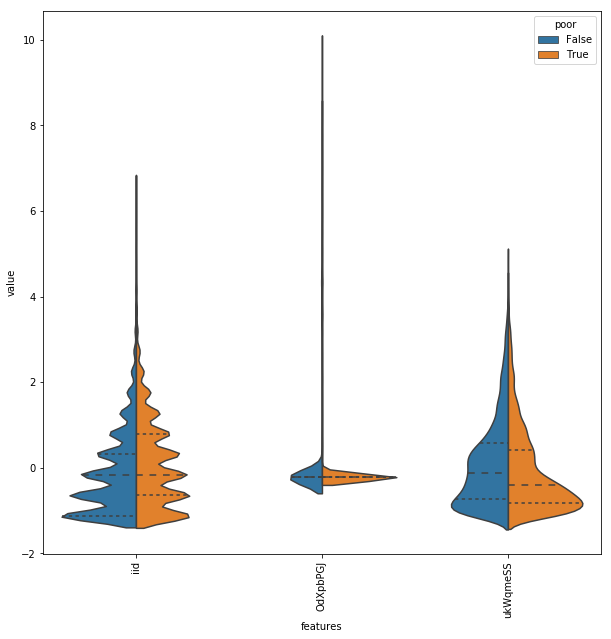

In [127]:
visualize_grassi(a_train_nums, ay_train)

In [128]:
def visualize_grassi_cate(x, y):
    data = pd.concat([y, x],axis=1)
    data = pd.melt(data, id_vars="poor",
                   var_name="features",
                   value_name='value')
    plt.figure(figsize=(10,10))
    sns.violinplot(x="features", y="value", hue="poor", data=data, split=True)
    plt.xticks(rotation=90)

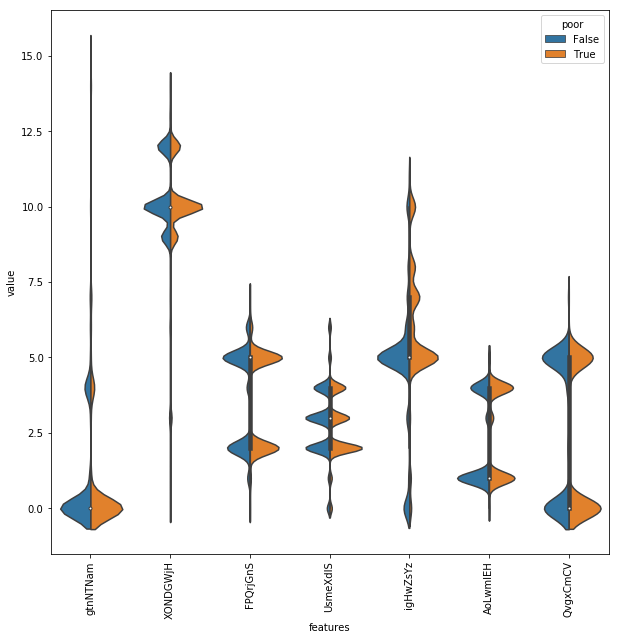

In [129]:
visualize_grassi_cate(a_train_cats, ay_train)

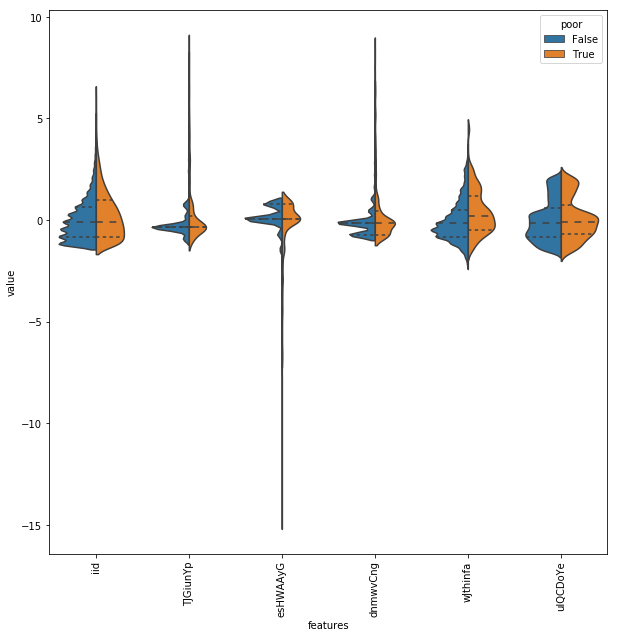

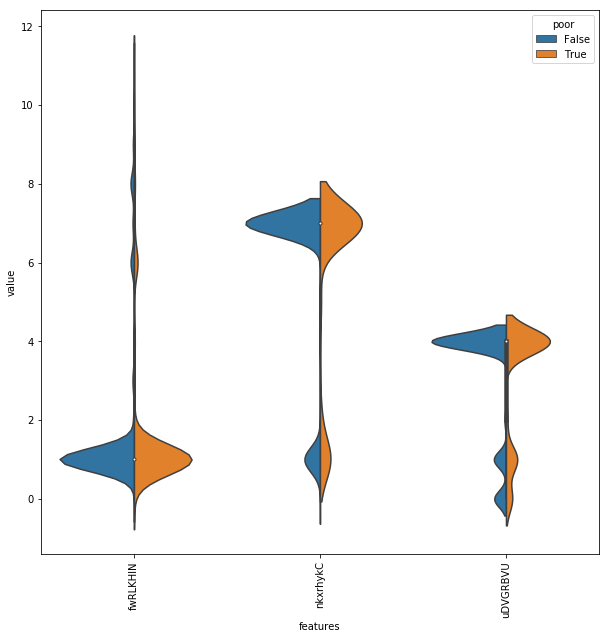

In [132]:
visualize_grassi(b_train_nums, by_train)
visualize_grassi_cate(b_train_cats, by_train)

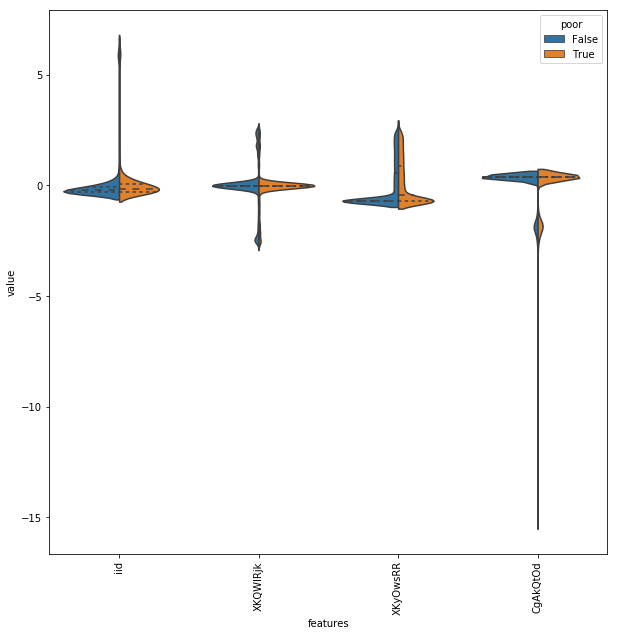

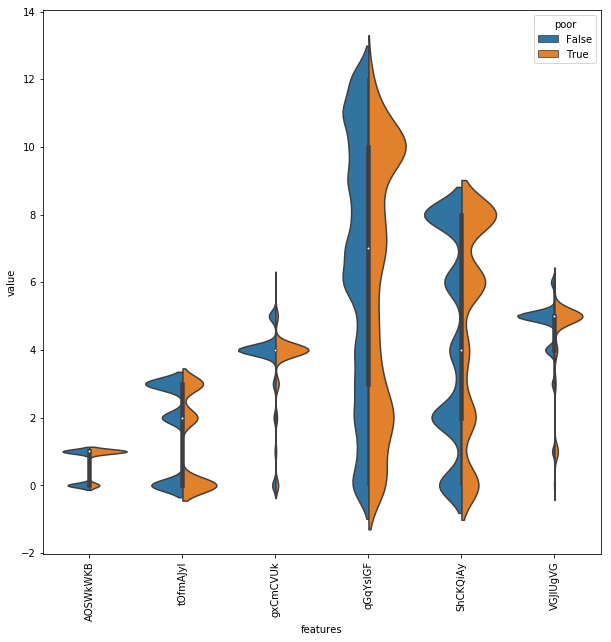

In [133]:
visualize_grassi(c_train_nums, cy_train)
visualize_grassi_cate(c_train_cats, cy_train)

Not sure if there are significant differences visually speaking, but they certainly don't look the same. Lets print the columns so we can work with them in our training script:

In [134]:
print("a_indiv_keep_cols = {}".format(a_train_small.columns.tolist()))
print("b_indiv_keep_cols = {}".format(b_train_small.columns.tolist()))
print("c_indiv_keep_cols = {}".format(c_train_small.columns.tolist()))

a_indiv_keep_cols = ['iid', 'gtnNTNam', 'OdXpbPGJ', 'XONDGWjH', 'FPQrjGnS', 'UsmeXdIS', 'igHwZsYz', 'AoLwmlEH', 'QvgxCmCV', 'ukWqmeSS', 'poor', 'country']
b_indiv_keep_cols = ['iid', 'TJGiunYp', 'esHWAAyG', 'fwRLKHlN', 'dnmwvCng', 'nkxrhykC', 'uDVGRBVU', 'wJthinfa', 'ulQCDoYe', 'poor', 'country']
c_indiv_keep_cols = ['iid', 'AOSWkWKB', 'XKQWlRjk', 'tOfmAJyI', 'XKyOwsRR', 'CgAkQtOd', 'gxCmCVUk', 'qGqYslGF', 'ShCKQiAy', 'VGJlUgVG', 'poor', 'country']


P.S.: it is worth noting that the column 'iid' is obviously correlated to poor/not poor label